# SWX1 Results Analysis

## Python Imports

In [1]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
from pyomo.environ import *

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
#warnings.filterwarnings('ignore')

## Install R Packages

In [2]:
# Using R inside python
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages

# Allow conversion
import rpy2.robjects as ro

from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# Install packages
packnames = ('rsm')
#utils.install_packages(StrVector(packnames))

# Load packages
rsm = importr('rsm')
base = importr('base')

In [3]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

## Process CSV Files

In [4]:

# importing the pandas library
import pandas as pd
  
# reading the csv file using read_csv
# storing the data frame in variable called df
df_cost = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/swx1_cost.txt', sep='\t')
df_time = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/swx1_time.txt', sep='\t')
  
# creating a list of column names by
# calling the .columns
list_of_columns_cost = list(df_cost.columns)
list_of_columns_time = list(df_time.columns)
  
# displaying the list of column names
print('List of Cost column names : ', 
      list_of_columns_cost)
print('List of Time column names : ', 
      list_of_columns_time)

List of Cost column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'cost']
List of Time column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'time']


In [5]:
display((Markdown("### Statistics for Cost")))
df_cost.cost.describe()

### Statistics for Cost

count    80.000000
mean      0.587500
std       0.021198
min       0.540000
25%       0.585000
50%       0.590000
75%       0.600000
max       0.620000
Name: cost, dtype: float64

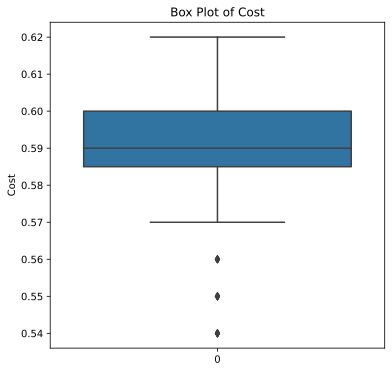

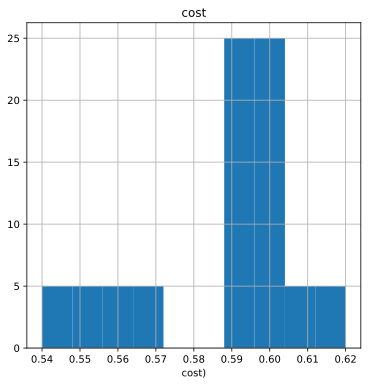

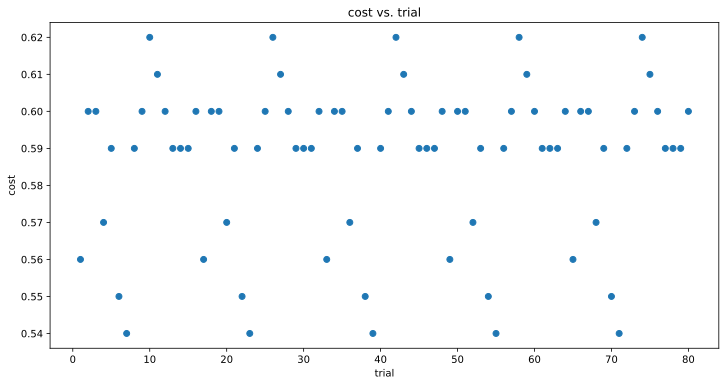

In [6]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_cost['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_cost['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_cost['trial'], df_cost['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()

In [7]:
display((Markdown("### Statistics for Time")))
df_time.time.describe()

### Statistics for Time

count       80.000000
mean     11655.975000
std       2979.686374
min       7737.000000
25%       8981.000000
50%      11343.500000
75%      14568.500000
max      18254.000000
Name: time, dtype: float64

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_time['time'])
plt.title('Box Plot of Time')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_time['time'].hist()
plt.title('time')
plt.xlabel('time)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_time['trial'], df_time['time'])
plt.title('time vs. trial')
plt.xlabel('trial')
plt.ylabel('time')
plt.show()

# Cost Analysis

In [8]:
display(Markdown("## Cost Ordinary Least Squares Regression - Coded"))
lm_cost_coded = statsmodels.formula.api.ols("cost ~ (lh+ps+id+rw+wt)**2", data=df_cost).fit()
print(lm_cost_coded.summary2())

display(Markdown("## Cost Ordinary Least Squares Regression - Actual"))
lm_cost_actual = statsmodels.formula.api.ols("cost ~ (alh+aps+aid+arw+awt)**2", data=df_cost).fit()
print(lm_cost_actual.summary2())


## Cost Ordinary Least Squares Regression - Coded

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      1.000     
Dependent Variable:    cost              AIC:                 -5576.9981
Date:                  2021-07-07 16:22  BIC:                 -5538.8856
No. Observations:      80                Log-Likelihood:      2804.5    
Df Model:              15                F-statistic:         9.103e+28 
Df Residuals:          64                Prob (F-statistic):  0.00      
R-squared:             1.000             Scale:               2.6000e-32
------------------------------------------------------------------------
           Coef.  Std.Err.           t            P>|t|   [0.025  0.975]
------------------------------------------------------------------------
Intercept  0.5875   0.0000 32588602530047648.0000 0.0000  0.5875  0.5875
lh         0.0025   0.0000   138674904383183.1719 0.0000  0.0025  0.0025
ps         0.0000   0.0000                 3.0792 0.0031  0.0000  0.0000

## Cost Ordinary Least Squares Regression - Actual

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      1.000     
Dependent Variable:  cost              AIC:                 -5151.9124
Date:                2021-07-07 16:22  BIC:                 -5113.8000
No. Observations:    80                Log-Likelihood:      2592.0    
Df Model:            15                F-statistic:         4.482e+26 
Df Residuals:        64                Prob (F-statistic):  0.00      
R-squared:           1.000             Scale:               5.2799e-30
----------------------------------------------------------------------
           Coef.  Std.Err.          t           P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept  0.1900   0.0000   7667651086107.2676 0.0000  0.1900  0.1900
alh        0.2500   0.0000   4452025684313.1777 0.0000  0.2500  0.2500
aps       -0.0000   0.0000              -0.3230 0.7477 -0.0000  0.0000
aid        0.4000   0.0000

## Cost Reduced Model

In [9]:
display(Markdown("## Cost Ordinary Least Squares Regression - Reduced"))
lm_cost_actual_reduced = statsmodels.formula.api.ols("cost ~ (alh+aps+aid+arw+awt+alh:aps+alh:aid+alh:arw+alh:awt+aps:awt+aid:awt+arw:awt)", data=df_cost).fit()
print(lm_cost_actual_reduced.summary2())



## Cost Ordinary Least Squares Regression - Reduced

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     1.000     
Dependent Variable:   cost             AIC:                -4886.0343
Date:                 2021-07-07 16:22 BIC:                -4855.0680
No. Observations:     80               Log-Likelihood:     2456.0    
Df Model:             12               F-statistic:        1.961e+25 
Df Residuals:         67               Prob (F-statistic): 0.00      
R-squared:            1.000            Scale:              1.5089e-28
---------------------------------------------------------------------
           Coef.  Std.Err.          t          P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept  0.1900   0.0000  1766339957357.5493 0.0000  0.1900  0.1900
alh        0.2500   0.0000   832789703472.7402 0.0000  0.2500  0.2500
aps       -0.0000   0.0000             -0.1834 0.8550 -0.0000  0.0000
aid        0.4000   0.0000  23187043950

In [10]:
print(lm_cost_actual_reduced.params)

Intercept    1.900000e-01
alh          2.500000e-01
aps         -2.636780e-16
aid          4.000000e-01
arw          3.750000e-01
awt          3.208333e-01
alh:aps      7.771561e-16
alh:aid     -7.105427e-15
alh:arw      4.218847e-15
alh:awt     -2.083333e-01
aps:awt     -2.645453e-17
aid:awt     -2.500000e-01
arw:awt     -3.125000e-01
dtype: float64


In [11]:
cb = (str(lm_cost_actual.params[0]))
cv1 = (str(lm_cost_actual.params[1]))
cv2 = (str(lm_cost_actual.params[2]))
cv3 = (str(lm_cost_actual.params[3]))
cv4 = (str(lm_cost_actual.params[4]))
cv5 = (str(lm_cost_actual.params[5]))
cv6 = (str(lm_cost_actual.params[6]))
cv7 = (str(lm_cost_actual.params[7]))
cv8 = (str(lm_cost_actual.params[8]))
cv9 = (str(lm_cost_actual.params[9]))
cv10 = (str(lm_cost_actual.params[10]))
cv11 = (str(lm_cost_actual.params[11]))
cv12 = (str(lm_cost_actual.params[12]))

In [12]:
eq_cost_actual = (
    cb + " + " + cv1 + "*model.X1" + " + " + cv2 + "*model.X2" +  " + " + cv3 + "*model.X3" + " + " 
    + cv4 + "*model.X4" + " + " + cv5 + "*model.X5" + " + " + cv6 + "*model.X1*model.X2" + " + " + cv7 
    + "*model.X1*model.X3" + " + " + cv8 + "*model.X1*model.X4" + " + " + cv9 + "*model.X1*model.X5" + " + " 
    + cv10 + "*model.X2*model.X5" + " + " + cv11 + "*model.X3*model.X5" + " + " + cv12 + "*model.X4*model.X5")


In [13]:
print(eq_cost_actual)

0.19000000000000483 + 0.2499999999999858*model.X1 + -1.1102230246251565e-16*model.X2 + 0.4000000000000028*model.X3 + 0.3749999999999943*model.X4 + 0.32083333333332775*model.X5 + 1.6653345369377348e-16*model.X1*model.X2 + 1.5987211554602254e-14*model.X1*model.X3 + 3.552713678800501e-15*model.X1*model.X4 + -0.20833333333333381*model.X1*model.X5 + 6.765421556309548e-17*model.X2*model.X5 + 3.8163916471489756e-17*model.X3*model.X5 + 9.063930161978817e-17*model.X4*model.X5


# Time Analysis

In [14]:
display(Markdown("## Time Ordinary Least Squares Regression - Coded"))
lm_time_coded = statsmodels.formula.api.ols("time ~ (lh+ps+id+rw+wt)**2", data=df_time).fit()
print(lm_time_coded.summary2())

display(Markdown("## Time Ordinary Least Squares Regression - Actual"))
lm_time_actual = statsmodels.formula.api.ols("time ~ (alh+aps+aid+arw+awt)**2", data=df_time).fit()
print(lm_time_actual.summary2())

## Time Ordinary Least Squares Regression - Coded

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.972     
Dependent Variable: time             AIC:                1234.5012 
Date:               2021-07-07 16:22 BIC:                1272.6136 
No. Observations:   80               Log-Likelihood:     -601.25   
Df Model:           15               F-statistic:        185.2     
Df Residuals:       64               Prob (F-statistic): 1.10e-46  
R-squared:          0.977            Scale:              2.4685e+05
-------------------------------------------------------------------
            Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
-------------------------------------------------------------------
Intercept 11655.9750  55.5483 209.8351 0.0000 11545.0046 11766.9454
lh        -2726.9000  55.5483 -49.0907 0.0000 -2837.8704 -2615.9296
ps         -713.1500  55.5483 -12.8384 0.0000  -824.1204  -602.1796
id         -213.1750  55.5483  -3.8377 0.0003  -324.1454  -102.204

## Time Ordinary Least Squares Regression - Actual

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.972     
Dependent Variable:    time              AIC:                 1234.5012 
Date:                  2021-07-07 16:22  BIC:                 1272.6136 
No. Observations:      80                Log-Likelihood:      -601.25   
Df Model:              15                F-statistic:         185.2     
Df Residuals:          64                Prob (F-statistic):  1.10e-46  
R-squared:             0.977             Scale:               2.4685e+05
------------------------------------------------------------------------
             Coef.     Std.Err.     t    P>|t|     [0.025       0.975]  
------------------------------------------------------------------------
Intercept  40212.0583  5357.8717  7.5052 0.0000   29508.4791  50915.6376
alh       -99617.0833 12141.8091 -8.2045 0.0000 -123873.1355 -75361.0312
aps         -162.2569    74.3211 -2.1832 0.0327    -310.7303    -13.7836

## Time Reduced Model

In [15]:
display(Markdown("## Time Ordinary Least Squares Regression - Reduced"))
lm_time_actual_reduced = statsmodels.formula.api.ols("time ~ (alh+aps+aid+arw+awt+alh:aps+alh:aid+alh:arw+aps:awt+aid:awt+arw:awt)", data=df_time).fit()
print(lm_time_actual_reduced.summary2())

## Time Ordinary Least Squares Regression - Reduced

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.972     
Dependent Variable:    time              AIC:                 1230.5554 
Date:                  2021-07-07 16:22  BIC:                 1259.1398 
No. Observations:      80                Log-Likelihood:      -603.28   
Df Model:              11                F-statistic:         254.7     
Df Residuals:          68                Prob (F-statistic):  1.04e-50  
R-squared:             0.976             Scale:               2.4441e+05
------------------------------------------------------------------------
             Coef.     Std.Err.     t    P>|t|     [0.025       0.975]  
------------------------------------------------------------------------
Intercept  43416.9917  4208.8388 10.3157 0.0000   35018.3846  51815.5987
alh       -98212.9167 11169.0985 -8.7933 0.0000 -120500.5057 -75925.3276
aps         -221.4653    57.8565 -3.8278 0.0003    -336.9162   -106.0144

In [16]:
print(lm_time_actual_reduced.params)

Intercept    43416.991667
alh         -98212.916667
aps           -221.465278
aid          11617.000000
arw         -11514.500000
awt          -2331.750000
alh:aps        815.069444
alh:aid     -21800.000000
alh:arw       5550.000000
aps:awt        -76.708333
aid:awt      -2557.500000
arw:awt       8909.375000
dtype: float64


In [17]:
tb = (str(lm_time_actual_reduced.params[0]))
tv1 = (str(lm_time_actual_reduced.params[1]))
tv2 = (str(lm_time_actual_reduced.params[2]))
tv3 = (str(lm_time_actual_reduced.params[3]))
tv4 = (str(lm_time_actual_reduced.params[4]))
tv5 = (str(lm_time_actual_reduced.params[5]))
tv6 = (str(lm_time_actual_reduced.params[6]))
tv7 = (str(lm_time_actual_reduced.params[7]))
tv8 = (str(lm_time_actual_reduced.params[8]))
tv9 = (str(lm_time_actual_reduced.params[9]))
tv10 = (str(lm_time_actual_reduced.params[10]))
tv11 = (str(lm_time_actual_reduced.params[11]))


In [18]:
eq_time_actual = (
    tb + " + " + tv1 + "*model.X1" + " + " + tv2 + "*model.X2" +  " + " + tv3 + "*model.X3" + " + " 
    + tv4 + "*model.X4" + " + " + tv5 + "*model.X5" + " + " + tv6 + "*model.X1*model.X2" + " + " 
    + tv7 + "*model.X1*model.X3" + " + " + tv8 + "*model.X1*model.X4" + " + " + tv9 + "*model.X2*model.X4" 
    + " + " + tv10 + "*model.X3*model.X5" + " + " + tv11 + "*model.X4*model.X5") 

In [19]:
print(eq_time_actual)

43416.99166666686 + -98212.91666666698*model.X1 + -221.4652777777751*model.X2 + 11616.999999999822*model.X3 + -11514.499999999996*model.X4 + -2331.750000000133*model.X5 + 815.0694444444416*model.X1*model.X2 + -21799.999999999804*model.X1*model.X3 + 5550.000000000007*model.X1*model.X4 + -76.70833333333832*model.X2*model.X4 + -2557.4999999999272*model.X3*model.X5 + 8909.375*model.X4*model.X5


## Equations

In [20]:
display(Markdown("Cost = "))
print(eq_cost_actual)

print("------")

display(Markdown("Time = "))
print(eq_time_actual)


Cost = 

0.19000000000000483 + 0.2499999999999858*model.X1 + -1.1102230246251565e-16*model.X2 + 0.4000000000000028*model.X3 + 0.3749999999999943*model.X4 + 0.32083333333332775*model.X5 + 1.6653345369377348e-16*model.X1*model.X2 + 1.5987211554602254e-14*model.X1*model.X3 + 3.552713678800501e-15*model.X1*model.X4 + -0.20833333333333381*model.X1*model.X5 + 6.765421556309548e-17*model.X2*model.X5 + 3.8163916471489756e-17*model.X3*model.X5 + 9.063930161978817e-17*model.X4*model.X5
------


Time = 

43416.99166666686 + -98212.91666666698*model.X1 + -221.4652777777751*model.X2 + 11616.999999999822*model.X3 + -11514.499999999996*model.X4 + -2331.750000000133*model.X5 + 815.0694444444416*model.X1*model.X2 + -21799.999999999804*model.X1*model.X3 + 5550.000000000007*model.X1*model.X4 + -76.70833333333832*model.X2*model.X4 + -2557.4999999999272*model.X3*model.X5 + 8909.375*model.X4*model.X5


# Optimization

In [21]:
model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)
model.X3 = Var(within=NonNegativeReals)
model.X4 = Var(within=NonNegativeReals)
model.X5 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= .28)
model.C2 = Constraint(expr = model.X2 <= 72)
model.C3 = Constraint(expr = model.X3 <= .25)
model.C4 = Constraint(expr = model.X4 <= .8)
model.C5 = Constraint(expr = model.X5 <= 1.2)

model.C6 = Constraint(expr = model.X1 >= .16)
model.C7 = Constraint(expr = model.X2 >= 60)
model.C8 = Constraint(expr = model.X3 >= .15)
model.C9 = Constraint(expr = model.X4 >= .4)
model.C10 = Constraint(expr = model.X5 >= .8)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == (0.6666666666666696 + -0.6666666666666643*model.X1 
                                            + -0.007222222222222213*model.X2 + 1.2666666666666537*model.X3 
                                            + 0.1583333333333345*model.X4 + 0.04583333333332712*model.X5 
                                            + 0.013888888888888784*model.X1*model.X2 
                                            + -1.6666666666666496*model.X1*model.X3 
                                            + 0.41666666666666874*model.X1*model.X4 
                                            + -0.20833333333333337*model.X1*model.X5 
                                            + 3.3480163086352377e-16*model.X2*model.X5 
                                            + -3.122502256758253e-17*model.X3*model.X5 
                                            + 0.0041666666666667195*model.X4*model.X5))
model.C_f2 = Constraint(expr = model.f2 == (-50827.158333333544 + 83025.83333333326*model.X1 
                                            + 1206.4763888888651*model.X2 + -159735.9999999997*model.X3 
                                            + 31323.749999999964*model.X4 + 52039.87500000024*model.X5 
                                            + -1930.9722222221862*model.X1*model.X2 
                                            + 307724.99999999936*model.X1*model.X3 
                                            + -76831.24999999993*model.X1*model.X4 
                                            + -900.5208333333308*model.X2*model.X4 
                                            + 96299.99999999981*model.X3*model.X5 
                                            + -15805.000000000036*model.X4*model.X5))
model.O_f1 = Objective(expr = model.f1, sense=minimize)
model.O_f2 = Objective(expr = model.f2, sense=minimize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=maximize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l, x3_l, x4_l, x5_l = [], [], [], [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    x3_l.append(value(model.X3))
    x4_l.append(value(model.X4))
    x5_l.append(value(model.X5))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))



( X1 , X2, X3, X4, X5 ) = ( 0.16000000090908614 , 72.00000053818182 , 0.14999999090909089 , 0.3999999939814202 , 0.800000054171104 )
f1 = 0.4513333210204703
f2 = 40311.07916734335
( X1 , X2, X3, X4, X5 ) = ( 0.2800000099999649 , 72.00000071995412 , 0.14999999000072234 , 0.800000009999963 , 0.7999999900000465 )
f1 = 0.572666661642395
f2 = 8373.522997802625
